In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import Necessary Files 


In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
import tensorflow
print(tensorflow.__version__)

2.7.0


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils  import plot_model

import pickle
from tqdm import tqdm
import string

import pandas as pd
import seaborn as sns

# Creating VGG16 Model for Extract Image Features

In [5]:
# Orginal VGG16 Model
vgg16 = VGG16()
vgg16.summary()
plot_model(vgg16, to_file='vgg16_model.png', show_shapes=True, show_layer_names=True)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
def get_image_feature_extractor_model(): 
    vgg16 = VGG16()
    image_feature_extractor_model = Model(inputs=vgg16.inputs, outputs=vgg16.get_layer('fc2').output) # Prepare VGG16 for Transfer learning
    return image_feature_extractor_model   

In [7]:
image_fe_model=get_image_feature_extractor_model()
image_fe_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
plot_model(image_fe_model, to_file='image_feature_extractor_model.png', show_shapes=True, show_layer_names=True) # Showing Model Description visually

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Extract Features From Each Image

In [9]:
# from os import listdir
# def extract_image_features(directory,image_fe_model):
#     features = []
#     for name in tqdm(listdir(directory)):
#         filename = directory + '/' + name
#         image = load_img(filename, target_size=(224, 224))
#         image = img_to_array(image)
#         x,y,z=image.shape
#         image = image.reshape((1, x, y, z))
#         image = preprocess_input(image)
#         feature = image_fe_model.predict(image, verbose=0)
#         image_id = name.split('.')[0] #get image id without format
#         features.append([image_id,feature])
#     return features

# directory = r'/content/drive/MyDrive/#Research/#ImageCaption/BornonImages'
# features = extract_image_features(directory,image_fe_model)
# import pickle
# with open( r'/content/drive/MyDrive/#Research/#ImageCaption/BornonImages/image_feature_vgg.pkl', 'wb') as file:
#     pickle.dump(features, file)

In [10]:
import pickle
with open( r'BornonImages/image_feature_vgg.pkl', 'rb') as file:
    features = pickle.load(file)
# features

In [11]:
import pandas as pd
df=pd.DataFrame(features, columns=['Image Id','Image Feature'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image Id       4106 non-null   object
 1   Image Feature  4106 non-null   object
dtypes: object(2)
memory usage: 64.3+ KB


,Image Id,Image Feature
0,3177,"[[3.3125296, 0.0, 0.0, 2.2000487, 0.34471732, ..."
1,3172,"[[0.0, 0.0, 0.14208671, 2.8226347, 0.0, 0.0, 0..."
2,3162,"[[0.0, 1.0850376, 1.7213755, 0.0, 0.0, 0.0, 0...."
3,3198,"[[0.0, 0.0, 0.094326496, 0.0, 0.124467224, 0.0..."
4,3102,"[[0.0, 0.0, 1.414273, 0.0, 2.8978157, 0.0, 0.0..."


# Load Captions

In [12]:
def load_caption(filename):
    with open(filename,'r',encoding="utf8") as fp:
        text=fp.read()
    mapping = {}
    for line in tqdm(text.split('\n')):
        tokens = line.split()
        if len(line) < 2: # There can be missing caption or blank line
            continue
        image_id, image_caption = tokens[0], tokens[1:] # first token -> image id, from 2nd one-> Caption
        image_id = image_id.split('.')[0]
        image_caption = ' '.join(image_caption) # converting all the caption token to sentense
        if image_id not in mapping:
            mapping[image_id] = [list()] # Creating a list againest each image as there can be multiple caption for single image
        mapping[image_id][0].append(image_caption)
    return mapping
file_dir=r"Bornon_Dataset-main/textFile/bornon_all_token.txt"
captions = load_caption(file_dir)

100%|██████████| 20439/20439 [00:00<00:00, 583850.68it/s]


In [13]:
df['Caption']=df['Image Id'].copy()
df['Caption']=df['Caption'].map(captions)
df

,Image Id,Image Feature,Caption
0,3177,"[[3.3125296, 0.0, 0.0, 2.2000487, 0.34471732, ...","[[চারটি চায়ের কাপ রয়েছে ।, চায়ের কাপে চা ঢা..."
1,3172,"[[0.0, 0.0, 0.14208671, 2.8226347, 0.0, 0.0, 0...","[[একটি বড় নৌকা রয়েছে ।, ডাঙ্গা একটি বড় নৌকা..."
2,3162,"[[0.0, 1.0850376, 1.7213755, 0.0, 0.0, 0.0, 0....","[[একটি ট্রেন আসছে ।, দু'ধারে ফসলি জমির মাঝে রে..."
3,3198,"[[0.0, 0.0, 0.094326496, 0.0, 0.124467224, 0.0...","[[সাগরে চর জেগেছে ।, সাগর চরে কিছু নৌকা বাঁধা ..."
4,3102,"[[0.0, 0.0, 1.414273, 0.0, 2.8978157, 0.0, 0.0...","[[একটি পাখি আছে ।, একটি কালো পাখি আছে ।, একটি ..."
...,...,...,...
4101,218,"[[0.0, 0.0, 0.0, 1.5800617, 0.0, 0.0, 0.0, 0.0...","[[কিছু নাস্তার প্লেট দেখা যাচ্ছে ।, একটি ফ্লোর..."
4102,273,"[[0.27854258, 0.0, 0.9427728, 0.0, 0.0, 0.0, 0...","[[কায়াকিঙ্গের একটি মুহূর্ত ।, কয়েকজন মানুষের ক..."
4103,120,"[[0.027016878, 0.0, 0.0, 0.0, 2.251215, 0.0, 0...","[[আবছা ভাবে একজন মানুষ ও শিশু দেখা যাচ্ছে ।, আ..."
4104,281,"[[0.0, 0.0, 1.3625104, 0.58974487, 1.2960742, ...","[[কাশফুলে ঢাকা একটি মাঠ দেখা যাচ্ছে ।, কাশফুলে..."


# Preprocessing Caption

In [14]:
import re
import string

df.dropna(subset = ["Caption"], inplace=True)

def preprocess_caption(image_captions):
    updated_captions=[]
    # print(image_captions)
    for caption in image_captions[0]: #we used image_captions[0] instead of image_captions to unwraping the outer []
        caption = caption.strip()
        caption = " ".join(caption.split())

        remove = string.punctuation
        remove = remove.replace("|", "") # don't remove hyphens
        pattern = r"[{}]".format(remove) # create the pattern
        caption = re.sub(pattern, "", caption) 
        caption = re.sub(' +', ' ', caption)
        updated_captions.append('startseq '+caption+' endseq ')
    return [updated_captions]  
df['Caption']=df['Caption'].apply(lambda img_captions:preprocess_caption(img_captions))
df

,Image Id,Image Feature,Caption
0,3177,"[[3.3125296, 0.0, 0.0, 2.2000487, 0.34471732, ...","[[startseq চারটি চায়ের কাপ রয়েছে । endseq , ..."
1,3172,"[[0.0, 0.0, 0.14208671, 2.8226347, 0.0, 0.0, 0...","[[startseq একটি বড় নৌকা রয়েছে । endseq , sta..."
2,3162,"[[0.0, 1.0850376, 1.7213755, 0.0, 0.0, 0.0, 0....","[[startseq একটি ট্রেন আসছে । endseq , startseq..."
3,3198,"[[0.0, 0.0, 0.094326496, 0.0, 0.124467224, 0.0...","[[startseq সাগরে চর জেগেছে । endseq , startseq..."
4,3102,"[[0.0, 0.0, 1.414273, 0.0, 2.8978157, 0.0, 0.0...","[[startseq একটি পাখি আছে । endseq , startseq এ..."
...,...,...,...
4101,218,"[[0.0, 0.0, 0.0, 1.5800617, 0.0, 0.0, 0.0, 0.0...",[[startseq কিছু নাস্তার প্লেট দেখা যাচ্ছে । en...
4102,273,"[[0.27854258, 0.0, 0.9427728, 0.0, 0.0, 0.0, 0...","[[startseq কায়াকিঙ্গের একটি মুহূর্ত । endseq ,..."
4103,120,"[[0.027016878, 0.0, 0.0, 0.0, 2.251215, 0.0, 0...",[[startseq আবছা ভাবে একজন মানুষ ও শিশু দেখা যা...
4104,281,"[[0.0, 0.0, 1.3625104, 0.58974487, 1.2960742, ...",[[startseq কাশফুলে ঢাকা একটি মাঠ দেখা যাচ্ছে ।...


Image Id         0
Image Feature    0
Caption          0
dtype: int64


<AxesSubplot:>

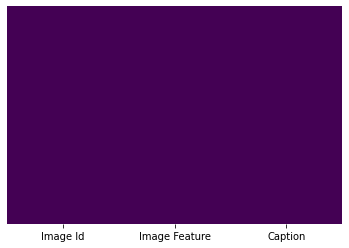

In [15]:
# Check if there are any missing value
print(df.isnull().sum(axis=0))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Now we have all the data in df Dataframe

# Separately Load Train Test Dev Data From Predefined Text File 

In [16]:
def get_data(file,df):
    with open(file,'r',encoding="utf8") as fp:
        doc=fp.read()
    data = []
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        id = line.split('.')[0]
        data.append(id)
    data=set(data)
    return df[df['Image Id'].isin(data)]    

In [17]:
# Load Training Data
filename =r"Bornon_Dataset-main/textFile/bornon_train_token.txt"
train = get_data(filename,df)
train

,Image Id,Image Feature,Caption
0,3177,"[[3.3125296, 0.0, 0.0, 2.2000487, 0.34471732, ...","[[startseq চারটি চায়ের কাপ রয়েছে । endseq , ..."
2,3162,"[[0.0, 1.0850376, 1.7213755, 0.0, 0.0, 0.0, 0....","[[startseq একটি ট্রেন আসছে । endseq , startseq..."
3,3198,"[[0.0, 0.0, 0.094326496, 0.0, 0.124467224, 0.0...","[[startseq সাগরে চর জেগেছে । endseq , startseq..."
4,3102,"[[0.0, 0.0, 1.414273, 0.0, 2.8978157, 0.0, 0.0...","[[startseq একটি পাখি আছে । endseq , startseq এ..."
5,3142,"[[0.0, 0.9932846, 0.30795476, 0.0, 0.0, 0.0, 2...","[[startseq বিশাল চা বাগান রয়েছে । endseq , st..."
...,...,...,...
4098,99,"[[0.0, 0.0, 0.0, 0.0, 0.61351717, 0.62780046, ...","[[startseq মোবাইলে কথা বলা একজন লোক । endseq ,..."
4101,218,"[[0.0, 0.0, 0.0, 1.5800617, 0.0, 0.0, 0.0, 0.0...",[[startseq কিছু নাস্তার প্লেট দেখা যাচ্ছে । en...
4102,273,"[[0.27854258, 0.0, 0.9427728, 0.0, 0.0, 0.0, 0...","[[startseq কায়াকিঙ্গের একটি মুহূর্ত । endseq ,..."
4103,120,"[[0.027016878, 0.0, 0.0, 0.0, 2.251215, 0.0, 0...",[[startseq আবছা ভাবে একজন মানুষ ও শিশু দেখা যা...


In [18]:
# # Load Dev Data
# filename = '/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt'
# dev = get_data(filename,df)
# dev

In [19]:
# Load Test Data
filename = r"Bornon_Dataset-main/textFile/bornon_test_token.txt"
test = get_data(filename,df)
test

,Image Id,Image Feature,Caption
1,3172,"[[0.0, 0.0, 0.14208671, 2.8226347, 0.0, 0.0, 0...","[[startseq একটি বড় নৌকা রয়েছে । endseq , sta..."
14,3107,"[[0.0, 1.4762948, 0.0, 5.9642463, 0.0, 0.0, 1....","[[startseq বনে দুটি বাঘ রয়েছে । endseq , star..."
16,3151,"[[1.7288276, 0.0, 0.0, 0.0, 5.1389303, 0.0, 1....","[[startseq দুইজন ব্যক্তি রয়েছে । endseq , sta..."
37,3110,"[[0.0, 0.0, 3.423864, 0.0, 4.2561307, 0.0, 1.2...","[[startseq একটি পাখি আছে । endseq , startseq এ..."
39,3169,"[[0.24135035, 0.9604883, 0.0, 0.42227882, 2.26...",[[startseq জলাভূমিতে কিচ্ছু নৌকা সাজানো রয়েছে...
...,...,...,...
4078,64,"[[1.8009146, 0.0, 2.4705272, 0.0, 0.0, 0.37894...",[[startseq শিশুর চোখের নিষ্পাপ চাহনি । endseq ...
4081,73,"[[0.72557825, 0.0, 0.0, 0.0, 0.0, 0.0, 3.11689...",[[startseq চেনা গন্তব্বে অচেনার খোঁজে । endseq...
4099,89,"[[0.0, 0.34387177, 0.13793707, 0.09150568, 2.2...",[[startseq রোদৌজ্জ্বল দুপুরের ক্লান্ত পথিক । e...
4100,95,"[[0.71901274, 5.3003306, 0.8062901, 0.0, 0.718...",[[startseq ব্ব্রিজ পার করতে থাকা একটি ট্রেন । ...


# Defining Some Helper Function

In [20]:
max_len_calculated = 64
!pip install transformers
from transformers import AutoModelForPreTraining, AutoTokenizer
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

def SagorBert():
  model = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
  # model = TFBertModel.from_pretrained("bert-base-multilingual-cased")
  tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
  # tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
  #model.eval()
  return tokenizer, model
bangla_tokenizer, bangla_model = SagorBert() 
def bert_encode(data):
    tokens = bangla_tokenizer.batch_encode_plus(data, max_length=max_len_calculated, padding='max_length', truncation=True)
    return tf.constant(tokens['input_ids'])

Some layers from the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at sagorsarker/bangla-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np


# Covert caption column to a list of captions
def to_lines(captions):
    all_caption = []
    for caption in captions:
        [all_caption.append(data) for data in caption[0]] # Again, we used caption[0] instead of caption to unwrap outer []
    return all_caption


# Fit a tokenizer to the given captions
def create_tokenizer(captions):
    lines = to_lines(captions)
    tokenizer = Tokenizer(oov_token = 1)
    tokenizer.fit_on_texts(lines)
    return tokenizer


# Calculate the length of the caption with most words
def max_length(captions):
    lines = to_lines(captions)
    max_len=max(len(d.split()) for d in lines)
    return max_len


# # Create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, caption_list, image, vocab_size):
    X1, X2, y = [], [], []
    
    for caption in caption_list:
        seq = caption.split(' ')
        # print('###################################\nOriginal Caption',caption)
        
        for i in range(1, len(seq)-1):
            input_seq, output_seq = seq[:i], seq[i]
            # print('Before texts_to_sequences --> inputseq -->', input_seq, '\toutput_seq --> ', output_seq )
            output_seq = tokenizer.texts_to_sequences([output_seq])[0] 
            # print('After texts_to_sequences --> inputseq --> ', input_seq, '\toutput_seq --> ', output_seq )
            
            merged_txt = ""
            for element in input_seq:
              merged_txt = merged_txt + " " + element 
            input_seq = bert_encode([merged_txt])
            # print('Merged Text: ', merged_txt)
            # print('Bert Tokenized : ',input_seq)
            input_seq = bangla_model(input_seq)
            output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
            # print('Output Sequence Onehot : ')
            # for i, el in enumerate(output_seq):
            #   if el != 0: 
            #     print(i)
            # print('\nOutput Sequence Shape : ',output_seq.shape,'Vocab Size: ', vocab_size  )
            # print( 'input_seq[0][0].shape, output_seq.shape',input_seq[0][0].shape,output_seq.shape )
            # print('Image',image[:5])
            X1.append(image)
            X2.append(input_seq[0][0])
            y.append(output_seq)
            # print(np.array(y).shape)
    # print( np.array(X1).shape, np.array(X2).shape, np.array(y).reshape(-1,1).shape)
    return np.asarray(X1), np.asarray(X2), np.asarray(y)

# def create_sequences(tokenizer, max_length, caption_list, image, vocab_size):
#     X1, X2, y = [], [], []
    
#     for caption in caption_list:
#         seq = tokenizer.texts_to_sequences([caption])[0]
#         for i in range(1, len(seq)):
#             input_seq, output_seq = seq[:i], seq[i]
#             input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
#             output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
#             print(input_seq.shape,output_seq.shape )
#             X1.append(image)
#             X2.append(input_seq)
#             y.append(output_seq)
#             print(np.array(y).shape)
#     return np.array(X1), np.array(X2), np.array(y)

# Below code is used to progressively load the batch of data
# Data generator will be called from model.fit_generator()
# We need to use this method rather fit to work with limited resource like RAM
def data_generator(data, tokenizer, max_length,vocab_size):
    # Loop for ever over images
    while 1:
        for image_id,image_feature,image_captions in data:
            image = image_feature[0]  # get image feature by unwraping outer []
            # print(image_id, '-----',image[:5])
            caption_list=image_captions[0] # get all the captions of an image by unwraping outer []
            # print('--------',caption_list,'--------')
            input_img, input_seq, output_word = create_sequences(tokenizer, max_length, caption_list, image,vocab_size)
            # print(input_img.shape, input_seq.shape, output_word.shape, '--------',type(input_img), type(input_seq), type(output_word))
            yield [[input_img, input_seq], output_word]

In [22]:
max_length(train['Caption'])

24

# Bert

# Building Model and Train

In [23]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

def build_model(vocab_size, max_length):
    # feature extractor model for image part
    inputs1 = Input(shape=(4096,))
    fe1 = Dense(512, activation='relu',kernel_initializer='he_uniform')(inputs1)
    fe2 = Dropout(0.5)(fe1)
    fe3 = Dense(256, activation='relu',kernel_initializer='he_uniform')(fe2)
    # sequence model for caption
    inputs2 = Input(shape=(max_length,768))
  
    se1 = inputs2
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, recurrent_dropout=0.2)(se2)
    # Mergeing Image and Sequence
    decoder1 = add([fe3, se3])
    decoder2 = Dense(256, activation='relu',kernel_initializer='he_uniform')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # Image+caption X->[image, seq]   y->[word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    sgd = tf.keras.optimizers.Adam(lr=0.00005, beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name="Adam")
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    # summarize model
    print(model.summary())
    return model

In [24]:
print('Train Data ' ,len(train))
tokenizer = create_tokenizer(train['Caption'])
print(tokenizer.texts_to_sequences(['জলাভূমিতে']))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ' , vocab_size)
max_len = max_length(train['Caption'])
print('Max Length: ' , max_len)

Train Data  3488
[[1]]
Vocabulary Size:  5353
Max Length:  24


In [25]:
max_len_calculated

64

In [26]:
model = build_model(vocab_size, max_len_calculated)
plot_model(model, to_file='image_captioning_model.png', show_shapes=True, show_layer_names=True) # Showing Model Description Visually

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          2097664     ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 768)]    0           []                               
                                                                                                  
 dropout_37 (Dropout)           (None, 512)          0           ['dense[0][0]']                  
                                                                                            

C:\Users\Admin\anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
# train_generator = data_generator(train.values, tokenizer, max_len_calculated,vocab_size)
# i = 0
# while True:
#   i+=1
#   print(i)
#   x = next(train_generator)
  
#   if i== 3500:
#     break

# dev_generator = data_generator(test.values, tokenizer, max_len_calculated, vocab_size)
# i=0
# print('--------')
# while True:
#   i+=1
#   print(i)
#   x = next(dev_generator)
  
#   if i== 3500:
#     break
train_generator = data_generator(train.values, tokenizer, max_len_calculated,vocab_size)

In [28]:
x = next(train_generator)
x

[[array([[3.3125296, 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ],
         [3.3125296, 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ],
         [3.3125296, 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ],
         ...,
         [3.3125296, 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ],
         [3.3125296, 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ],
         [3.3125296, 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32),
  array([[[ 1.4750965 ,  1.1387188 ,  1.7412034 , ..., -0.286674  ,
           -1.0593104 , -0.14788672],
          [ 1.1080915 , -0.15249713,  0.6446228 , ...,  0.38424388,
           -0.7198979 ,  0.46056375],
          [ 1.4082086 ,  0.64033306,  1.826217  , ...,  0.26168945,
           -0.20956251,  0.5708787 ],
          ...,
          [ 1.721721  , -0.03325674,  1.1539526 , ...,  0.15190053,
            0.14

# Data Generator and Train

In [29]:
from keras.callbacks import ModelCheckpoint
# define checkpoint callback
filepath = r'Saved Model/bert-lstm-model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', )


import tensorflow as tf
num_epoch= 50
train_generator = data_generator(train.values, tokenizer, max_len_calculated,vocab_size)
dev_generator = data_generator(test.values, tokenizer, max_len_calculated, vocab_size)
with tf.device('/gpu:0'):
  model.fit_generator(train_generator, epochs=num_epoch, steps_per_epoch=len(train)/8, validation_data=dev_generator,validation_steps=len(test)/16,callbacks=[checkpoint],verbose=1)

C:\Users\Admin\AppData\Local\Temp/ipykernel_15048/1827473020.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=num_epoch, steps_per_epoch=len(train)/8, validation_data=dev_generator,validation_steps=len(test)/16,callbacks=[checkpoint],verbose=1)


Epoch 1/50
436/436 [==============================] - ETA: 0s - loss: 5.7194 - accuracy: 0.2042
Epoch 00001: val_loss improved from inf to 4.73792, saving model to Saved Model\bert-lstm-model-ep001-loss5.719-val_loss4.738.h5
436/436 [==============================] - 1348s 3s/step - loss: 5.7194 - accuracy: 0.2042 - val_loss: 4.7379 - val_accuracy: 0.2992
Epoch 2/50


C:\Users\Admin\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


436/436 [==============================] - ETA: 0s - loss: 4.8664 - accuracy: 0.2702
Epoch 00002: val_loss did not improve from 4.73792
436/436 [==============================] - 1468s 3s/step - loss: 4.8664 - accuracy: 0.2702 - val_loss: 4.9169 - val_accuracy: 0.2672
Epoch 3/50
436/436 [==============================] - ETA: 0s - loss: 3.9013 - accuracy: 0.4027
Epoch 00003: val_loss did not improve from 4.73792
436/436 [==============================] - 1246s 3s/step - loss: 3.9013 - accuracy: 0.4027 - val_loss: 5.5296 - val_accuracy: 0.2844
Epoch 4/50
436/436 [==============================] - ETA: 0s - loss: 3.9905 - accuracy: 0.4234
Epoch 00004: val_loss improved from 4.73792 to 4.15571, saving model to Saved Model\bert-lstm-model-ep004-loss3.990-val_loss4.156.h5
436/436 [==============================] - 1264s 3s/step - loss: 3.9905 - accuracy: 0.4234 - val_loss: 4.1557 - val_accuracy: 0.3592
Epoch 5/50
436/436 [==============================] - ETA: 0s - loss: 4.2649 - accuracy: 

Epoch 30/50
436/436 [==============================] - ETA: 0s - loss: 3.2610 - accuracy: 0.4429
Epoch 00030: val_loss did not improve from 3.22482
436/436 [==============================] - 1404s 3s/step - loss: 3.2610 - accuracy: 0.4429 - val_loss: 3.8170 - val_accuracy: 0.4488
Epoch 31/50
436/436 [==============================] - ETA: 0s - loss: 3.0412 - accuracy: 0.4794
Epoch 00031: val_loss did not improve from 3.22482
436/436 [==============================] - 1545s 4s/step - loss: 3.0412 - accuracy: 0.4794 - val_loss: 5.0185 - val_accuracy: 0.3105
Epoch 32/50
436/436 [==============================] - ETA: 0s - loss: 3.5201 - accuracy: 0.4093
Epoch 00032: val_loss did not improve from 3.22482
436/436 [==============================] - 1421s 3s/step - loss: 3.5201 - accuracy: 0.4093 - val_loss: 4.2800 - val_accuracy: 0.3971
Epoch 33/50
436/436 [==============================] - ETA: 0s - loss: 3.2871 - accuracy: 0.4240
Epoch 00033: val_loss did not improve from 3.22482
436/436 [

# Load Saved Model

In [30]:
# saved_model_path = 'Saved Model/bert-lstm-model-ep006-loss4.146-val_loss3.467.h5'
# model.load_weights(saved_model_path)

# Train History

In [31]:
train_history=pd.DataFrame(model.history.history)
train_history

,loss,accuracy,val_loss,val_accuracy
0,5.719446,0.204180,4.737923,0.299213
1,4.866432,0.270222,4.916874,0.267247
2,3.901331,0.402711,5.529602,0.284404
3,3.990478,0.423398,4.155707,0.359170
4,4.264881,0.373414,3.845089,0.428233
5,4.149024,0.381137,3.575848,0.407873
6,3.968984,0.435597,3.858660,0.380538
7,4.443431,0.370526,4.499934,0.321909
8,4.042643,0.385896,4.546344,0.365983
9,3.873111,0.379078,4.079010,0.415182


<AxesSubplot:>

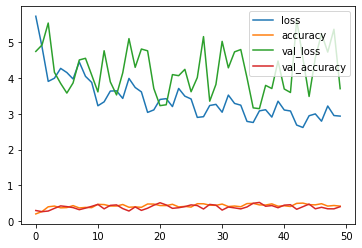

In [32]:
train_history.plot()

In [33]:
print('Minimum Loss\n',train_history.min()['val_loss'])
print('-----')
print('Minimum Loss on epoch: \n',train_history.idxmin()['val_loss']+1)

Minimum Loss
 3.140841245651245
-----
Minimum Loss on epoch: 
 37


Looks like model at epoch 19 had performed best at dev set


# Evaluation

In [45]:
# Give a unique id to a word
def word_for_id(id, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == id:
            return word
    return None

# Generate a caption for an image
def generate_caption(model, tokenizer, image, max_length):
    input_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # sequence = tmodel.encode([input_text])
        input_seq = bert_encode([input_text])
        input_seq = bangla_model(input_seq)
        input_seq = input_seq[0]


        # print(sequence)
        # Predict next word
        # print(image.shape,input_seq.shape )
       
        pred_b = model.predict([image, input_seq], verbose=0)
        pred = np.argmax(pred_b) # Remember it returns word Index
        # print(pred_b,'\t',pred)
        word = word_for_id(pred, tokenizer)
        # Stop if we cannot find the word
#         print('Input Text: ', input_text, 'Prediction: ', pred, 'Word: ', word)
#         print('\nIF: ',image[0][:5], '\nIS',input_seq[:5], '\nWORD: ', word)

        if word is None:
            break
        # Generate next input_text
        input_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break

    return input_text


# # Generate a caption for an image
# def generate_caption(model, tokenizer, image, max_length):
#     input_text = 'startseq'
#     # iterate over the whole length of the sequence
#     for i in range(max_length):
#         sequence = tokenizer.texts_to_sequences([input_text])[0]
#         sequence = pad_sequences([sequence], maxlen=max_length)
#         # Predict next word
#         pred_b = model.predict([image,sequence], verbose=0)
#         pred = np.argmax(pred_b) # Remember it returns word Index
#         # print(pred_b,'\t',pred)
#         word = word_for_id(pred, tokenizer)
#         # Stop if we cannot find the word
#         if word is None:
#             break
#         # Generate next input_text
#         input_text += ' ' + word
#         # stop if we predict the end of the sequence
#         if word == 'endseq':
#             break

#     return input_text

from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook
def evaluate_model(model, test, tokenizer, max_len):
    actual, predicted = [], []
    # step over the whole set
    for img_id, img_feature, caption_list in tqdm_notebook(test):
        prediction = generate_caption(model, tokenizer, img_feature, max_len)
        ground_truth = [d.split() for d in caption_list[0]]
        actual.append(ground_truth)
        predicted.append(prediction.split())

    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


In [46]:
# from tensorflow.keras.models import load_model

# # Load the best model
# filename = r"C:\Users\Admin\#ImageCaption\model-ep002-loss3.445-val_loss3.981.h5"
# model = load_model(filename)

# evaluate model
evaluate_model(model, test.values, tokenizer, max_len)

  0%|          | 0/600 [00:00<?, ?it/s]

BLEU-1: 0.611241
BLEU-2: 0.469422
BLEU-3: 0.349670
BLEU-4: 0.187549


In [48]:
model.save(r'C:\Users\Admin\#ImageCaption\Lastepoch.h5')

# Checking Model

In [36]:
def extract_features_of_single_photo(filename,model):
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
def show_result(img_dir,image_fe_model):
    img_feature = extract_features_of_single_photo(img_dir,image_fe_model)
    # print(img_feature[0][:5])
    caption = generate_caption(model, tokenizer, img_feature, max_len_calculated).split()
    caption=' '.join(caption[1:len(caption)-1])
    print(caption)
    
    #Plot
    plt.axis('off')      
    img=mpimg.imread(img_dir)
    imgplot = plt.imshow(img)
    plt.title(caption)
    plt.show()    

In [37]:
import warnings
warnings.filterwarnings('ignore')

Input Text:  startseq Prediction:  5 Word:  একটি

IF:  [0. 0. 0. 0. 0.] 
IS tf.Tensor(
[[[ 1.4750965   1.1387188   1.7412034  ... -0.286674   -1.0593104
   -0.14788672]
  [ 1.1080915  -0.15249713  0.6446228  ...  0.38424388 -0.7198979
    0.46056375]
  [ 1.4082086   0.64033306  1.826217   ...  0.26168945 -0.20956251
    0.5708787 ]
  ...
  [ 1.721721   -0.03325674  1.1539526  ...  0.15190053  0.14398967
    0.634163  ]
  [ 1.8583742  -0.00522216  1.2509305  ...  0.17913845  0.13117772
    0.5336137 ]
  [ 1.8283669   0.15372951  1.3976763  ...  0.18428002  0.14013475
    0.53098667]]], shape=(1, 64, 768), dtype=float32) 
WORD:  একটি
Input Text:  startseq একটি Prediction:  35 Word:  পাখি

IF:  [0. 0. 0. 0. 0.] 
IS tf.Tensor(
[[[ 1.342203    0.6836855   1.7329967  ...  0.21460941 -0.6876741
   -0.15364248]
  [ 0.06546824 -0.03835118  0.5436279  ...  1.4557278  -0.00862954
   -0.78658926]
  [ 1.0441141  -1.3733596   2.2005398  ...  1.1473345  -1.1915022
   -0.15958835]
  ...
  [ 1.6971611 

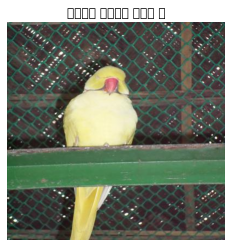

In [38]:
img_dir=r"784.jpg"
show_result(img_dir,image_fe_model)

Input Text:  startseq Prediction:  10 Word:  একজন

IF:  [2.0806272 2.1699595 0.        0.        2.1998305] 
IS tf.Tensor(
[[[ 1.4750965   1.1387188   1.7412034  ... -0.286674   -1.0593104
   -0.14788672]
  [ 1.1080915  -0.15249713  0.6446228  ...  0.38424388 -0.7198979
    0.46056375]
  [ 1.4082086   0.64033306  1.826217   ...  0.26168945 -0.20956251
    0.5708787 ]
  ...
  [ 1.721721   -0.03325674  1.1539526  ...  0.15190053  0.14398967
    0.634163  ]
  [ 1.8583742  -0.00522216  1.2509305  ...  0.17913845  0.13117772
    0.5336137 ]
  [ 1.8283669   0.15372951  1.3976763  ...  0.18428002  0.14013475
    0.53098667]]], shape=(1, 64, 768), dtype=float32) 
WORD:  একজন
Input Text:  startseq একজন Prediction:  79 Word:  মেয়ে

IF:  [2.0806272 2.1699595 0.        0.        2.1998305] 
IS tf.Tensor(
[[[ 8.2931453e-01  4.3464801e-01  1.5866132e+00 ...  1.2353361e-01
   -5.9479469e-01  2.8059380e-02]
  [-2.1716534e-01 -5.2264065e-01  7.0896924e-01 ...  6.7118579e-01
   -4.6340933e-01 -1.6129297

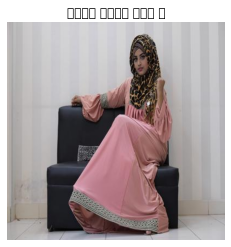

In [39]:
# Set the directory where your image belongs
img_dir=r"954.jpg"
show_result(img_dir,image_fe_model)

Input Text:  startseq Prediction:  5 Word:  একটি

IF:  [4.0531983  2.7104762  0.         0.         0.10194886] 
IS tf.Tensor(
[[[ 1.4750965   1.1387188   1.7412034  ... -0.286674   -1.0593104
   -0.14788672]
  [ 1.1080915  -0.15249713  0.6446228  ...  0.38424388 -0.7198979
    0.46056375]
  [ 1.4082086   0.64033306  1.826217   ...  0.26168945 -0.20956251
    0.5708787 ]
  ...
  [ 1.721721   -0.03325674  1.1539526  ...  0.15190053  0.14398967
    0.634163  ]
  [ 1.8583742  -0.00522216  1.2509305  ...  0.17913845  0.13117772
    0.5336137 ]
  [ 1.8283669   0.15372951  1.3976763  ...  0.18428002  0.14013475
    0.53098667]]], shape=(1, 64, 768), dtype=float32) 
WORD:  একটি
Input Text:  startseq একটি Prediction:  11 Word:  মানুষ

IF:  [4.0531983  2.7104762  0.         0.         0.10194886] 
IS tf.Tensor(
[[[ 1.342203    0.6836855   1.7329967  ...  0.21460941 -0.6876741
   -0.15364248]
  [ 0.06546824 -0.03835118  0.5436279  ...  1.4557278  -0.00862954
   -0.78658926]
  [ 1.0441141  -1.373

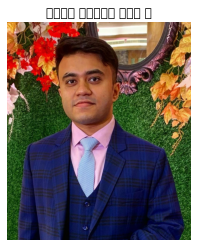

In [42]:
# Set the directory where your image belongs
img_dir=r"Farzad.jpg"
show_result(img_dir,image_fe_model)

Input Text:  startseq Prediction:  5 Word:  একটি

IF:  [2.4491796 0.753337  0.        0.        0.       ] 
IS tf.Tensor(
[[[ 1.4750965   1.1387188   1.7412034  ... -0.286674   -1.0593104
   -0.14788672]
  [ 1.1080915  -0.15249713  0.6446228  ...  0.38424388 -0.7198979
    0.46056375]
  [ 1.4082086   0.64033306  1.826217   ...  0.26168945 -0.20956251
    0.5708787 ]
  ...
  [ 1.721721   -0.03325674  1.1539526  ...  0.15190053  0.14398967
    0.634163  ]
  [ 1.8583742  -0.00522216  1.2509305  ...  0.17913845  0.13117772
    0.5336137 ]
  [ 1.8283669   0.15372951  1.3976763  ...  0.18428002  0.14013475
    0.53098667]]], shape=(1, 64, 768), dtype=float32) 
WORD:  একটি
Input Text:  startseq একটি Prediction:  11 Word:  মানুষ

IF:  [2.4491796 0.753337  0.        0.        0.       ] 
IS tf.Tensor(
[[[ 1.342203    0.6836855   1.7329967  ...  0.21460941 -0.6876741
   -0.15364248]
  [ 0.06546824 -0.03835118  0.5436279  ...  1.4557278  -0.00862954
   -0.78658926]
  [ 1.0441141  -1.3733596   2.2

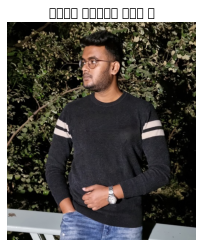

In [41]:

# Set the directory where your image belongs
img_dir=r"shawon.jpg"
show_result(img_dir,image_fe_model)

একটি রঙের রঙের রঙের রঙের রঙের ।


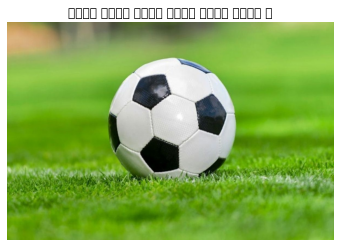

In [54]:
img_dir=r"football.jpg"
show_result(img_dir,image_fe_model)

# All the best

In [ ]:
%%capture
!pip3 install transformers

In [ ]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from transformers import BertTokenizer, TFBertModel

def SagorBert():
  model = TFBertModel.from_pretrained("sagorsarker/bangla-bert-base")
  # model = TFBertModel.from_pretrained("bert-base-multilingual-cased")
  # tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
  tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
  #model.eval()
  return tokenizer, model



In [ ]:
%%capture
tokenizer, model = SagorBert() 

In [ ]:
import tensorflow as tf
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length= 24, padding='max_length', truncation=True)
    return tf.constant(tokens['input_ids'])

In [ ]:
# max_length = 128
sentences =   "আমি ভাত খাই"
            
              

In [ ]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=24, padding='max_length', truncation=True)
    return tf.constant(tokens['input_ids'])

In [ ]:
v = bert_encode([sentences])
v.shape

In [ ]:
v

In [ ]:
a = model(v)

In [ ]:
a[0].shape

# Another model

...neuropark/sahajBERT

...ai4bharat/indic-bert

monsoon-nlp/bangla-electra

bert-base-multilingual-cased

In [ ]:
# bangla_tokenizer, bangla_model = SagorBert() 
# def bert_encode(data):




In [ ]:
sentences =   "আমি ভাত খাই"
input_seq = bert_encode([sentences])
           
input_seq = bangla_model(input_seq)

In [ ]:
input_seq['pooler_output']

In [ ]:
input_seq[0][0]

In [ ]:
input_seq[0]